# Задание 1

Анализируется сайт по бронированию экскурсий.

В файле csv набор данных, в котором:
dimensions: event category, event action, event label
metrics: total events, unique events

●	1 строка = 1 вариант совершенного  события

●	event action - название действия события, где Page Visit - всегда посещение (= пользователь открыл страницу сайта), остальные события - всегда клики по элементам страницы (кнопки, чекбоксы)

в данном случае элементы - это фильтры на мобильной версии сайта, которые можно увидеть.

●	event label - дополнительная информация по событию
в лейбле на 1 месте всегда название города
там, где в лейбле через / написано что-то еще - это текст, по которому пользователь кликнул. там встречается много грязных данных
●	metrics: это количество всех (total events) и уникальных (unique events) событий, которые были затреканы на сайте

например:
City Page |	Page Visit |	Perm |	2353 |	1564
означает, что пользователей посетили страницу города Пермь 1564 уникальных раза (= кол-во сессий) и 2353 раза всего (за сессию 1 пользователь мог несколько раз быть на 1 странице)

например2:
price_button_submit |	Petrozavodsk / Показать предложения (38) |	6 |	6
означает, что пользователи на странице города Петрозаводск 6 раз нажали на кнопку “Показать предложения”, то есть применили фильтр. в момент этого нажатия именно у этих людей была надпись  Показать предложения (38), 38 в данном случае - кол-во предложений, выбранных фильтром

также на странице города Петрозаводск другие люди могли нажимать кнопку с событием price_button_submit, но event label мог быть другим



Поставленная задача:

необходимо проанализировать использование фильтров пользователями на страницах городов. вопросы, на которые стоит ответить:
1.	сколько людей пользуются фильтрами?
2.	в каких городах фильтрами пользуются больше? в каких меньше?
3.	какие разделы фильтров наиболее востребованы? “фильтры”, “сортировка”, “категории”?
4.	как часто люди пользуются выбором цены?

не обязательно: любые дополнительные инсайты, полученные в результате исследования.

*важно! в event label много грязных данных. оттуда можно убрать числа. там могут встречаться разные вещи. это нормально, можно поступать с этим так, как покажется правильным.


## Загрузка данных

In [ ]:
import pandas as pd

df=pd.read_csv('events filters Product Analyst.csv')
df

,event_category,event_action,event_label,total_events,unique_events
0,city_landing,price_button_submit,Tula / Показать предложения (11),8,7
1,city_landing,price_button_submit,Sochi / Показать предложения (39),12,10
2,city_landing,search-tools-button_open,Penza / Сортировка,2,2
3,city_landing,filters-categories_click,Gelendzhik / ЭКСКУРСИИ В ГЕЛЕНДЖИКЕ ЦЕНЫ,1,1
4,city_landing,price_button_submit,Moscow / Показать предложения (345),2,2
...,...,...,...,...,...
19087,city_landing,search-tools-button_open,Istanbul / ЭКСКУРСИИ В СТАМБУЛЕ,38,32
19088,city_landing,filters-categories_click,Ufa / Пешеходные,3,3
19089,city_landing,search-tools-button_open,Yerevan / Фильтры Выбрано: 0,16,16
19090,city_landing,price_button_submit,Pskov / Показать предложения (35),7,7


In [ ]:
df.dtypes

,0
event_category,object
event_action,object
event_label,object
total_events,int64
unique_events,int64


In [ ]:
df.event_category.value_counts()

,count
event_category,
city_landing,18441
City Page,651


## Подготовка данных

In [ ]:
df.event_label.nunique()

16222

Различных комбинаций слишком много, анализ такого столбца будет не информативен, разделим данные на город и действия на странице этого города (без цифр, знаков и прочего шума).

In [ ]:
import re

# Функция для очистки текста после '/'
def clean_text(text):
    if pd.isna(text):
        return None
    # Удаляем цифры, скобки, лишние пробелы
    cleaned = re.sub(r'[0-9()]', '', text).strip()
    # Удаляем многоточия и спецсимволы
    cleaned = re.sub(r'[^\w\s]', '', cleaned)
    return cleaned if cleaned else None

# Создаем столбцы 'city' и 'text'
df[['city', 'raw_text']] = df['event_label'].str.split('/', n=1, expand=True)
df['city'] = df['city'].str.strip()  # Чистим город
df['text'] = df['raw_text'].apply(clean_text)  # Чистим текст

# Удаляем временный столбец
df.drop('raw_text', axis=1, inplace=True)

df

,event_category,event_action,event_label,total_events,unique_events,city,text
0,city_landing,price_button_submit,Tula / Показать предложения (11),8,7,Tula,Показать предложения
1,city_landing,price_button_submit,Sochi / Показать предложения (39),12,10,Sochi,Показать предложения
2,city_landing,search-tools-button_open,Penza / Сортировка,2,2,Penza,Сортировка
3,city_landing,filters-categories_click,Gelendzhik / ЭКСКУРСИИ В ГЕЛЕНДЖИКЕ ЦЕНЫ,1,1,Gelendzhik,ЭКСКУРСИИ В ГЕЛЕНДЖИКЕ ЦЕНЫ
4,city_landing,price_button_submit,Moscow / Показать предложения (345),2,2,Moscow,Показать предложения
...,...,...,...,...,...,...,...
19087,city_landing,search-tools-button_open,Istanbul / ЭКСКУРСИИ В СТАМБУЛЕ,38,32,Istanbul,ЭКСКУРСИИ В СТАМБУЛЕ
19088,city_landing,filters-categories_click,Ufa / Пешеходные,3,3,Ufa,Пешеходные
19089,city_landing,search-tools-button_open,Yerevan / Фильтры Выбрано: 0,16,16,Yerevan,Фильтры Выбрано
19090,city_landing,price_button_submit,Pskov / Показать предложения (35),7,7,Pskov,Показать предложения


In [ ]:
df.city.nunique()

651

In [ ]:
df.text.nunique()

1477

Кол-во городов совпадает с количеством City Page в event_category. Но нужно детальнее проверить, нет ли повторов (по разному написанных) и прочей путаницы.

In [ ]:
# Функция для определения языка строки
def detect_language(text):
    if re.search('[а-яА-ЯёЁ]', str(text)):
        return 'ru'
    else:
        return 'en'

# Добавляем столбец с языком
df['language'] = df['city'].apply(detect_language)

# Сортируем по языку
df.sort_values(by='language')

,event_category,event_action,event_label,total_events,unique_events,city,text,language
0,city_landing,price_button_submit,Tula / Показать предложения (11),8,7,Tula,Показать предложения,en
12731,city_landing,price_button_submit,Barcelona / Показать предложения (48),2,2,Barcelona,Показать предложения,en
12730,city_landing,search-tools-button_open,Ayia Napa / Категории Индивидуальные,1,1,Ayia Napa,Категории Индивидуальные,en
12729,city_landing,price_button_submit,Amsterdam / Показать предложения (57),1,1,Amsterdam,Показать предложения,en
12728,city_landing,price_button_submit,Pereslavl-Zalessky / Показать предложения (3),4,4,Pereslavl-Zalessky,Показать предложения,en
...,...,...,...,...,...,...,...,...
6359,city_landing,dates_filter_mobile,Uglich / Сегодня,1,1,Uglich,Сегодня,en
6365,city_landing,filters-categories_click,Kaliningrad / ЭКСКУРСИИ В КАЛИНИНГРАДЕ 2021,7,3,Kaliningrad,ЭКСКУРСИИ В КАЛИНИНГРАДЕ,en
6272,city_landing,start_date_click,Poreс,1,1,Poreс,None,ru
3538,City Page,Page Visit,Poreс,72,61,Poreс,None,ru


In [ ]:
df[df.city=='Poreс'] # скопировала из таблицы выше

,event_category,event_action,event_label,total_events,unique_events,city,text,language
3538,City Page,Page Visit,Poreс,72,61,Poreс,None,ru
6272,city_landing,start_date_click,Poreс,1,1,Poreс,None,ru
10645,city_landing,end_date_click,Poreс,1,1,Poreс,None,ru


In [ ]:
df[df.city=='Poreс'] # русская буква с в конце

,event_category,event_action,event_label,total_events,unique_events,city,text,language
3538,City Page,Page Visit,Poreс,72,61,Poreс,None,ru
6272,city_landing,start_date_click,Poreс,1,1,Poreс,None,ru
10645,city_landing,end_date_click,Poreс,1,1,Poreс,None,ru


Те же строки, значит в этом городе опечатка и русская буква в конце. Посмотрю, есть ли правильно написанные города.

In [ ]:
df[df.city=='Porec'] # с анкгийской буквой этот город нигде не написан

,event_category,event_action,event_label,total_events,unique_events,city,text,language


In [ ]:
df['city'] = df['city'].str.replace('с$', 'c', regex=True) # Исправление
# Повторная проверка
df['language'] = df['city'].apply(detect_language)
df.language.value_counts()

,count
language,
en,19092


Теперь убедились, что все города на английском.

In [ ]:
df=df.drop(columns='language')
df.head(2)

,event_category,event_action,event_label,total_events,unique_events,city,text
0,city_landing,price_button_submit,Tula / Показать предложения (11),8,7,Tula,Показать предложения
1,city_landing,price_button_submit,Sochi / Показать предложения (39),12,10,Sochi,Показать предложения


Поиск дублей в городах

In [ ]:
# Приводим города к нижнему регистру и удаляем пробелы/спецсимволы
df_check=df.copy()
df_check['city_cleaned'] = (
    df_check['city']
    .str.lower()
    .str.replace('[^a-zа-яё]', '', regex=True)
)

# Группируем по очищенным названиям и выводим дубли
duplicates = df_check.groupby('city_cleaned')['city'].unique().apply(list)
duplicates = duplicates[duplicates.apply(len) > 1]  # Только группы с дублями

print("Потенциальные дубли:")
for cleaned_name, variants in duplicates.items():
    print(f"{cleaned_name}: {variants}")

Потенциальные дубли:
sovetsk: ['Sovetsk', 'sovetsk']


In [ ]:
df[df.city=='Sovetsk']

,event_category,event_action,event_label,total_events,unique_events,city,text
4165,City Page,Page Visit,Sovetsk,1,1,Sovetsk,None
7873,city_landing,search-tools-button_open,Sovetsk / Фильтры,1,1,Sovetsk,Фильтры
12162,city_landing,end_date_click,Sovetsk,1,1,Sovetsk,None
12556,city_landing,clear_filter_mobile,Sovetsk,1,1,Sovetsk,None
14406,city_landing,start_date_click,Sovetsk,1,1,Sovetsk,None
18481,city_landing,price_button_close,Sovetsk,1,1,Sovetsk,None


In [ ]:
df[df.city=='sovetsk']

,event_category,event_action,event_label,total_events,unique_events,city,text
10453,City Page,Page Visit,sovetsk,29,20,sovetsk,None


In [ ]:
# Приведение к единому регистру
for col in ['city']:
    df[col] = df[col].str.title()

In [ ]:
df[df.city=='sovetsk']

,event_category,event_action,event_label,total_events,unique_events,city,text


In [ ]:
df.event_category.value_counts()

,count
event_category,
city_landing,18441
City Page,651


In [ ]:
df.city.nunique()

650

In [ ]:
df[(df.event_category=='City Page') & (df.event_action!='Page Visit')]

,event_category,event_action,event_label,total_events,unique_events,city,text


In [ ]:
df[(df.event_category!='City Page') & (df.event_action=='Page Visit')]

,event_category,event_action,event_label,total_events,unique_events,city,text


Различная нужная агрегация будет при дальнешйем анализе.

Немного подробнее рассмотрим столбец с текстом, на который кликнул пользователь.

In [ ]:
df.text.value_counts().head(20)

,count
text,
Показать предложения,7138
Выбрано,770
По рейтингу,440
Сначала самые дешевые,371
Сначала самые популярные,329
Фильтры Выбрано,318
Все,307
Фильтры,294
Групповая,286


Это популярные кнопки, это понятно, но есть много непопулярных, которые различны, встречаются 1 раз, но схожи по смыслу. Например, "Экскурсии в *городе "

In [ ]:
df.text.value_counts().tail(20)

,count
text,
Категории Круизы и теплоходные прогулки,1
Оленья ферма,1
Ираклион,1
Alles,1
ТВЕРЬ ЭКСКУРСИИ ПО ГОРОДУ СБОРНЫЕ,1
ЗЕЛЕНОГРАДСК ЭКСКУРСИИ НА КУРШСКУЮ,1
Красноярская ГЭС,1
ЭКСКУРСИИ ИЗ ЖЕЛЕЗНОВОДСКА ЦЕНЫ И РАСПИСАНИЕ,1
Категории ЭКСКУРСИИ В ОСОБНЯКИ МОСКВЫ,1


Появилась идея, что для дальнейшего анализа может быть интересно сделать новый столбец с сокращенныыми по смыслу текстами кнопок.

In [ ]:
# Очистка текста
def clean_text(text):
    if pd.isna(text):
        return None
    text = text.lower()  # к нижнему регистру
    text = re.sub(r'[^\w\s]', '', text)  # удаляем знаки препинания
    return text.strip()

df['text_clean'] = df['text'].apply(clean_text)

In [ ]:
# с помощью этой ячейки текст обрабатывается таким образом, что убираются окончания и можно лучше понять, когда текст на самом деле одинаковый
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer("russian")

def stem_text(text):
    if pd.isna(text):
        return None
    words = text.split()
    stemmed = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed)

df['text_stemmed'] = df['text_clean'].apply(stem_text)
df

,event_category,event_action,event_label,total_events,unique_events,city,text,text_clean,text_stemmed
0,city_landing,price_button_submit,Tula / Показать предложения (11),8,7,Tula,Показать предложения,показать предложения,показа предложен
1,city_landing,price_button_submit,Sochi / Показать предложения (39),12,10,Sochi,Показать предложения,показать предложения,показа предложен
2,city_landing,search-tools-button_open,Penza / Сортировка,2,2,Penza,Сортировка,сортировка,сортировк
3,city_landing,filters-categories_click,Gelendzhik / ЭКСКУРСИИ В ГЕЛЕНДЖИКЕ ЦЕНЫ,1,1,Gelendzhik,ЭКСКУРСИИ В ГЕЛЕНДЖИКЕ ЦЕНЫ,экскурсии в геленджике цены,экскурс в геленджик цен
4,city_landing,price_button_submit,Moscow / Показать предложения (345),2,2,Moscow,Показать предложения,показать предложения,показа предложен
...,...,...,...,...,...,...,...,...,...
19087,city_landing,search-tools-button_open,Istanbul / ЭКСКУРСИИ В СТАМБУЛЕ,38,32,Istanbul,ЭКСКУРСИИ В СТАМБУЛЕ,экскурсии в стамбуле,экскурс в стамбул
19088,city_landing,filters-categories_click,Ufa / Пешеходные,3,3,Ufa,Пешеходные,пешеходные,пешеходн
19089,city_landing,search-tools-button_open,Yerevan / Фильтры Выбрано: 0,16,16,Yerevan,Фильтры Выбрано,фильтры выбрано,фильтр выбра
19090,city_landing,price_button_submit,Pskov / Показать предложения (35),7,7,Pskov,Показать предложения,показать предложения,показа предложен


In [ ]:
df.text_stemmed.value_counts()

,count
text_stemmed,
показа предложен,7138
выбра,770
группов,508
по рейтинг,440
снача сам дешев,371
...,...
экскурс ужас петербург,1
тематическ экскурс по петербург,1
экскурс по иркутск на автобус,1


Все строки с "экскурс" + город и/или уточнение заменю на просто "экскурс":

In [ ]:
# Создаем новый столбец
df['text_generalized'] = df['text_stemmed'].apply(
    lambda x: 'экскурс' if pd.notna(x) and 'экскурс' in x.split() else x
)
df=df.drop(columns=['text_clean'])

In [ ]:
df.text_generalized.value_counts()

,count
text_generalized,
показа предложен,7138
экскурс,1759
выбра,770
группов,508
по рейтинг,440
...,...
олен ферм,1
ираклион,1
стамбул экскурсион автобус,1


Стало в 3 раза меньше различных строк.

In [ ]:
df.text_generalized.value_counts().tail(20)

,count
text_generalized,
дельфинар,1
индивидульн,1
категор для дет,1
дивногорск,1
категор прогулк по москверек,1
москвасит,1
красноярск гэс,1
skiptheline tickets,1
хам,1


In [ ]:
df.text_generalized.value_counts().head(20)

,count
text_generalized,
показа предложен,7138
экскурс,1759
выбра,770
группов,508
по рейтинг,440
снача сам дешев,371
снача сам популярн,329
фильтр выбра,318
все,307


Проверю что City Page всегда с городом без действия.

In [ ]:
df[(df.event_category=='City Page') & (df.text.notna())]

,event_category,event_action,event_label,total_events,unique_events,city,text,text_clean,text_stemmed


Посмотрим что под одним event_action могут быть различные тексты, на которые кликают пользователи.

In [ ]:
df[df.event_action=='price_button_submit'].text_generalized.value_counts()

,count
text_generalized,
показа предложен,7138
нич не найд,129
show offers,37
экскурс,34
показат пропозиції,7
angebote anzeigen,6
nothing found,1
nichts gefunden,1
הצג הצעות,1


Видим, что текст может быть на разных языках и в целом различный. Счиать ли это шумом или это может оказаться важным для анализа? Пока не ясно, для анализа использования фильтров, я бы не считала это грязными данными.

In [ ]:
df[df.event_action=='search-tools-button_open'].text_generalized.value_counts()

,count
text_generalized,
экскурс,891
выбра,770
фильтр выбра,318
все,307
фильтр,294
...,...
кармадонск ущел,1
категор из тбилис по груз,1
категор гид по тбилис,1


Итоговый дата сет для анализа:

In [ ]:
df.head()

,event_category,event_action,event_label,total_events,unique_events,city,text,text_stemmed,text_generalized
0,city_landing,price_button_submit,Tula / Показать предложения (11),8,7,Tula,Показать предложения,показа предложен,показа предложен
1,city_landing,price_button_submit,Sochi / Показать предложения (39),12,10,Sochi,Показать предложения,показа предложен,показа предложен
2,city_landing,search-tools-button_open,Penza / Сортировка,2,2,Penza,Сортировка,сортировк,сортировк
3,city_landing,filters-categories_click,Gelendzhik / ЭКСКУРСИИ В ГЕЛЕНДЖИКЕ ЦЕНЫ,1,1,Gelendzhik,ЭКСКУРСИИ В ГЕЛЕНДЖИКЕ ЦЕНЫ,экскурс в геленджик цен,экскурс
4,city_landing,price_button_submit,Moscow / Показать предложения (345),2,2,Moscow,Показать предложения,показа предложен,показа предложен


## Вопрос 1: Сколько людей пользуются фильтрами?

Основной вопрос что считать использованием фильтров. Можно же просто открыть раздел с фильтрами и закрыть, это использование?

Если под фильтрами понимать все event_action, кроме Page Visit. Уникальных пользователей определяем по unique_events.

In [ ]:
# Посещения страниц города
page_visits = df[df['event_action'] == 'Page Visit']['unique_events'].sum()

# Все взаимодействия с фильтрами
filter_events = df[df['event_action'] != 'Page Visit']['unique_events'].sum()

# % пользователей, взаимодействующих с фильтрами
filter_usage_rate = round(100 * filter_events / page_visits, 2)
print('Кол-во уникальных посетителей страниц городов: ', page_visits)
print('Кол-во уникальных посетителей, взаимодействующих с фильтрами: ', filter_events)
print('Процент уникальных посетителей, перешедших на страницу городов и воспользовавшихся фильтрами: ', filter_usage_rate, '%')

Кол-во уникальных посетителей страниц городов:  1384478
Кол-во уникальных посетителей, взаимодействующих с фильтрами:  294969
Процент уникальных посетителей, перешедших на страницу городов и воспользовавшихся фильтрами:  21.31 %


Интересно посмотреть график по всем event_action.

<ipython-input-19-f7a88e8292f1>:39: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




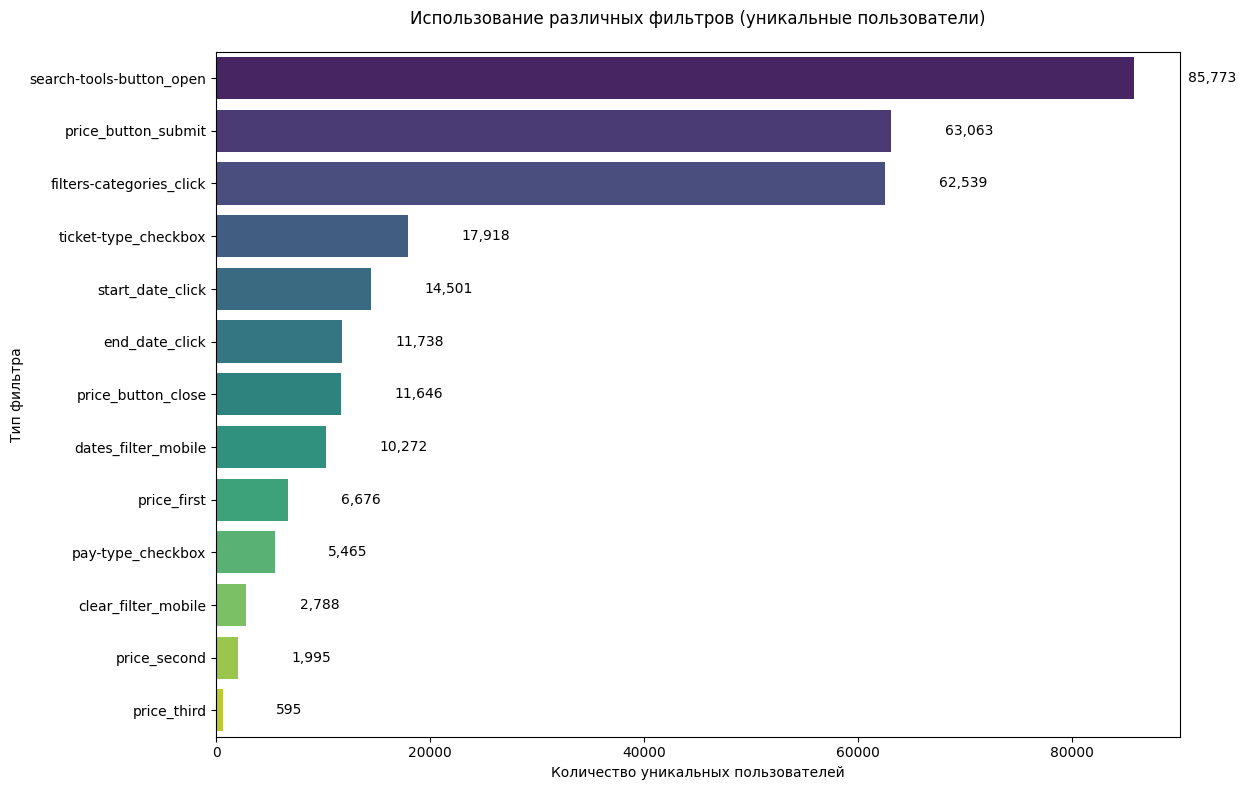

In [ ]:
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Подготовка данных
filter_usage = df[df['event_action'] != 'Page Visit'].groupby('event_action')['unique_events'].sum().reset_index()
filter_usage = filter_usage.sort_values('unique_events', ascending=False)

# Создаем красивый bar chart с Plotly
fig = px.bar(filter_usage,
             x='unique_events',
             y='event_action',
             orientation='h',
             title='Использование различных фильтров (уникальные пользователи)',
             labels={'unique_events': 'Количество уникальных пользователей',
                    'event_action': 'Тип фильтра'},
             color='unique_events',
             color_continuous_scale='Viridis',
             height=600)

# Добавляем подписи с абсолютными значениями и процентами
fig.update_traces(texttemplate='%{x:,}',
                  textposition='outside',
                  hovertemplate='<b>%{y}</b><br>Пользователей: %{x:,}<br>')

# Настраиваем оформление
fig.update_layout(
    yaxis={'categoryorder': 'total ascending'},
    xaxis={'title': 'Количество уникальных пользователей'},
    coloraxis_showscale=False,
    hoverlabel=dict(bgcolor='white', font_size=12),
    margin=dict(l=100, r=50, t=80, b=80)
)

fig.show()

# Альтернативный вариант с Seaborn (для статических отчетов)
plt.figure(figsize=(12, 8))
sns.barplot(data=filter_usage,
            y='event_action',
            x='unique_events',
            palette='viridis')

plt.title('Использование различных фильтров (уникальные пользователи)', pad=20)
plt.xlabel('Количество уникальных пользователей')
plt.ylabel('Тип фильтра')
plt.tight_layout()

# Добавляем подписи с абсолютными значениями
for i, value in enumerate(filter_usage['unique_events']):
    plt.text(value + 5000, i, f'{value:,}', va='center')

plt.show()

По этим графикам уже можно проанализировать, сколько людей пользуются каждым конкретным фильтром.

-  Ось X: Количество уникальных пользователей
-  Ось Y: Тип фильтра

Данные представлены в виде горизонтальных столбцов, упорядоченных по убыванию количества пользователей. Ключевые наблюдения:

-  Самый популярный фильтр: "search-tools-button_open" (85,773 пользователей), что логично, так как это метка в целом для открытия раздела фильтров.
-  Наименее популярные фильтры: "price_second" и "price_third" (1,995 и 595 пользователей соответственно). Это может говорить о том, что такие варианты задания цены пока не популярны.

В целом, график предоставляет информацию о том, какие фильтры наиболее важны для пользователей. Эти данные могут быть использованы для оптимизации пользовательского интерфейса и улучшения опыта поиска.

## Вопрос 2 В каких городах фильтрами пользуются больше? в каких меньше?

Посчитаем кол-во уникальных действий по городам.

In [ ]:
# Отфильтруем события, связанные с фильтрами
filters_only = df[df['event_action'] != 'Page Visit']

# Сгруппируем по городам
city_filter_usage = filters_only.groupby('city')['unique_events'].sum().sort_values(ascending=False)
city_filter_usage.head(5)

,unique_events
city,
Kaliningrad,25239
Saint Petersburg,23732
Moscow,15802
Sochi,12791
Istanbul,11578


В Калининграде фильтрами пользуются больше всего.

In [ ]:
city_filter_usage.tail(20)

,unique_events
city,
Plovdiv,2
San Sebastian,2
Ivangorod,2
Alicante,1
Orlando,1
Noginsk,1
Yakutsk,1
Montevideo,1
Ischia,1


В таблице выше перечислены города, в которых фильтрами пользуются меньше всего. Можно предположить, что в этих городах в целом не так много экскурсий пока представлено на сайте и пользователи анализируют их без фильтров.

Посмотрим наглядно, топ 3 города, и топ 3 фильтра:

In [ ]:
import plotly.express as px
from plotly.subplots import make_subplots

# Фильтруем ключевые действия
key_actions = ['search-tools-button_open', 'filters-categories_click', 'price_button_submit']
filters_df = df[df['event_action'].isin(key_actions)]

# Группируем по городам
city_stats = filters_df.groupby('city')['unique_events'].sum().reset_index()
city_stats = city_stats.sort_values('unique_events', ascending=False)

# Топ-3 и топ-20 с конца
top_cities = city_stats.head(3)
bottom_cities = city_stats.tail(20)

# Создаем комбинированный график
fig = make_subplots(rows=1, cols=2, subplot_titles=("Топ-3 городов", "20 городов с наименьшим использованием"), shared_yaxes=True)

# Топ-3
fig.add_trace(
    go.Bar(
        x=top_cities['city'],
        y=top_cities['unique_events'],
        name='Топ-3',
        marker_color='#1f77b4',
        hovertemplate='<b>%{x}</b><br>Пользователей: %{y:,}<extra></extra>'
    ),
    row=1, col=1
)

# 20 с конца
fig.add_trace(
    go.Bar(
        x=bottom_cities['city'],
        y=bottom_cities['unique_events'],
        name='20 с конца',
        marker_color='#ff7f0e',
        hovertemplate='<b>%{x}</b><br>Пользователей: %{y:,}<extra></extra>'
    ),
    row=1, col=2
)

# Настраиваем оформление
fig.update_layout(
    title_text='Использование ключевых фильтров по городам',
    height=500,
    showlegend=False,
    yaxis_title='Количество уникальных пользователей',
    hovermode='x unified'
)

fig.show()

Построим интерактивный график, который можно перестраивать задавая город в выпадающем списке (новые график строится снизу под предыдущими). Это может быть полезно, чтобы анализировать фильтры в разных городах, где какие чаще используются.

In [ ]:
from ipywidgets import interact, Dropdown
import plotly.express as px
from IPython.display import display

# Подготовка данных для всех фильтров
all_filters = df[df['event_action'] != 'Page Visit']
city_filter_stats = all_filters.groupby(['city', 'event_action'])['unique_events'].sum().reset_index()

# Получаем список городов и сортируем его
cities = sorted(city_filter_stats['city'].unique())

# Создаем выпадающий список городов с первым городом по умолчанию
city_dropdown = Dropdown(
    options=cities,
    value=cities[0],  # Устанавливаем первый город по умолчанию
    description='Город:',
    style={'description_width': 'initial'}
)

# Функция для обновления графика
def plot_city_filters(city_name):
    city_data = city_filter_stats[city_filter_stats['city'] == city_name].sort_values('unique_events', ascending=False)

    # Проверяем, есть ли данные для выбранного города
    if city_data.empty:
        print(f"Нет данных по фильтрам для города {city_name}")
        return

    fig = px.bar(
        city_data,
        x='unique_events',
        y='event_action',
        orientation='h',
        title=f'Использование фильтров в городе {city_name}',
        labels={'unique_events': 'Количество уникальных пользователей', 'event_action': 'Тип фильтра'},
        color='unique_events',
        color_continuous_scale='Viridis',
        height=500
    )

    fig.update_traces(
        texttemplate='%{x:,}',
        textposition='outside',
        hovertemplate='<b>%{y}</b><br>Пользователей: %{x:,}<extra></extra>'
    )

    fig.update_layout(
        yaxis={'categoryorder': 'total ascending'},
        coloraxis_showscale=False,
        hoverlabel=dict(bgcolor='white', font_size=12),
        margin=dict(l=100)  # Добавляем отступ слева для длинных названий
    )

    # Выводим график
    display(fig)

# Сначала отображаем график для первого города
plot_city_filters(cities[0])

# Затем создаем интерактивный элемент
print("\nВыберите город для детального анализа:")
interact(plot_city_filters, city_name=city_dropdown)


Выберите город для детального анализа:


interactive(children=(Dropdown(description='Город:', options=('Abakan', 'Abkhazia', 'Abrau-Durso', 'Abu Dhabi'…

Интересно рассмотреть в процентах: процент уникальных пользователей воспользовавшихся фильтрами от всего уникальных пользователей по городу.

In [ ]:
# Расчет доли использования фильтров по городам
city_stats = df.groupby('city').agg({
    'total_events': 'sum',
    'unique_events': 'sum'
}).reset_index()

city_filter_usage = df[df['event_action'] != 'Page Visit'].groupby('city')['unique_events'].sum().reset_index()
city_filter_usage = city_filter_usage.merge(city_stats[['city', 'unique_events']],
                                          on='city',
                                          suffixes=('_filter', '_total'))
city_filter_usage['usage_rate'] = city_filter_usage['unique_events_filter'] / city_filter_usage['unique_events_total'] * 100
city_filter_usage.sort_values('usage_rate', ascending=False)

,city,unique_events_filter,unique_events_total,usage_rate
336,Stresa,4,6,66.666667
217,Miass,13,23,56.521739
237,Nevyansk,5,9,55.555556
205,Manama,6,12,50.000000
12,Amiens,5,10,50.000000
...,...,...,...,...
363,Tunis,3,162,1.851852
131,Herzliya,1,58,1.724138
298,Rovinj,1,61,1.639344
264,Pechory,1,91,1.098901


In [ ]:
city_filter_usage[city_filter_usage.city=='Kaliningrad']

,city,unique_events_filter,unique_events_total,usage_rate
151,Kaliningrad,25239,93235,27.070306


Так мы видим, что, несмотря на то, что Калининград - лидер по использованию фильтров, процент пользователей, использующих фильтры не самый большой, хотя тоже в пределах нормы.

Такой анализ именно соотношений может быть полезен по следующим причинам:

-  Выявление "скрытых возможностей": Города с небольшим общим трафиком, но высоким процентом использования фильтров, могут указывать на то, что пользователи в этих городах особенно нуждаются в фильтрах или они очень эффективны для этой аудитории. Это может быть связано с особенностями спроса в этом регионе, специфическими запросами пользователей или даже более высокой осведомленностью о функционале фильтров. Игнорирование этих городов на основе абсолютных значений пропустит важные инсайты.
-  Обнаружение проблем в крупных городах: Сравнение процента использования фильтров между разными городами позволяет выявить города, где использование фильтров относительно низкое, даже если в абсолютных цифрах там много пользователей, использующих фильтры. Низкий процент в крупном городе может указывать на проблемы с удобством фильтров, их видимостью или соответствием потребностям пользователей этого региона. Может также сигнализировать, что категорий слишком много и пользователю сложно в них ориентироваться. В абсолютных цифрах это может быть не сразу заметно, потому что общее количество пользователей все равно будет высоким.
-  Сравнение эффективности фильтров в разных контекстах: Процент использования фильтров - это показатель эффективности фильтров в определенном регионе. Он говорит о том, какая доля аудитории считает фильтры полезными для достижения своей цели. Это может быть связано с языковыми, культурными или экономическими особенностями региона.
-  Приоритизация улучшений: Определение городов с низким процентом использования фильтров позволяет приоритизировать усилия по улучшению фильтров для конкретных регионов. Например, если в крупном городе процент низкий, стоит провести UX-исследование и выяснить, что именно не устраивает пользователей.
-  Обнаружение паттернов использования в нишевых аудиториях: В небольших городах с высоким процентом использования фильтров могут быть сконцентрированы нишевые аудитории с очень специфическими потребностями. Анализ того, какие фильтры используются в этих городах, может дать ценные сведения о потребностях этих аудиторий.

Однако есть и недостатки анализа доли использования фильтров:

-  Нестабильность результатов для очень маленьких городов: В городах с очень небольшим трафиком, даже небольшое изменение в количестве пользователей, использующих фильтры, может существенно повлиять на процент. Поэтому результаты для таких городов нужно интерпретировать с осторожностью и учитывать статистическую значимость.
-  Не репрезентативность: Если выборка пользователей из какого-то города очень маленькая или нерепрезентативна, процент использования фильтров может быть искаженным.

Важно учитывать абсолютные значения вместе с относительными, а также для определённых выводов проводить доп исследования и сегментацию пользователей.

## Вопрос 3 Какие разделы фильтров наиболее востребованы? “фильтры”, “сортировка”, “категории”?

Для такого анализа использовать только event_action не релевантно, так как многие метки отвечают сразу за всё и фильтры и категории и сортировку. Поэтому было решено использовать текст кнопок, на которые нажимают пользователи. Идея: сделать новый столбец с категориями "фильтры", "сортировка", "категории", "другое".

In [ ]:
df.text_generalized.value_counts().head(60)

,count
text_generalized,
показа предложен,7138
экскурс,1759
выбра,770
группов,508
по рейтинг,440
снача сам дешев,371
снача сам популярн,329
фильтр выбра,318
все,307


In [ ]:
df[df.text_generalized=='показа предложен'].event_action.value_counts()

,count
event_action,
price_button_submit,7138


Эта кнопка для всех разделов, поэтому этот пункт не берём в рассмотрение.

In [ ]:
df[df.text_generalized=='экскурс'].event_action.value_counts()

,count
event_action,
search-tools-button_open,891
filters-categories_click,581
ticket-type_checkbox,253
price_button_submit,34


In [ ]:
df[(df.text_generalized=='экскурс')].head(50)

,event_category,event_action,event_label,total_events,unique_events,city,text,text_stemmed,text_generalized
3,city_landing,filters-categories_click,Gelendzhik / ЭКСКУРСИИ В ГЕЛЕНДЖИКЕ ЦЕНЫ,1,1,Gelendzhik,ЭКСКУРСИИ В ГЕЛЕНДЖИКЕ ЦЕНЫ,экскурс в геленджик цен,экскурс
22,city_landing,search-tools-button_open,Adler / КАКИЕ ЭКСКУРСИИ В АДЛЕРЕ,1,1,Adler,КАКИЕ ЭКСКУРСИИ В АДЛЕРЕ,как экскурс в адлер,экскурс
23,city_landing,filters-categories_click,Saint Petersburg / СЕМЕЙНЫЕ ЭКСКУРСИИ В ПЕТЕРБ...,2,1,Saint Petersburg,СЕМЕЙНЫЕ ЭКСКУРСИИ В ПЕТЕРБУРГЕ,семейн экскурс в петербург,экскурс
39,city_landing,search-tools-button_open,Pyatigorsk / ОБЗОРНАЯ ЭКСКУРСИЯ ПО ПЯТИГОРСКУ,3,3,Pyatigorsk,ОБЗОРНАЯ ЭКСКУРСИЯ ПО ПЯТИГОРСКУ,обзорн экскурс по пятигорск,экскурс
53,city_landing,search-tools-button_open,Tula / ЭКСКУРСИИ ПО ТУЛЕ,1,1,Tula,ЭКСКУРСИИ ПО ТУЛЕ,экскурс по тул,экскурс
57,city_landing,search-tools-button_open,Prague / ЭКСКУРСИИ ПРАГА,8,6,Prague,ЭКСКУРСИИ ПРАГА,экскурс праг,экскурс
63,city_landing,search-tools-button_open,Anapa / Категории ЭКСКУРСИИ АНАПА 2021 АВГУСТ,1,1,Anapa,Категории ЭКСКУРСИИ АНАПА АВГУСТ,категор экскурс анап август,экскурс
67,city_landing,search-tools-button_open,Sortavala / ЭКСКУРСИЯ В КИЖИ ИЗ СОРТАВАЛА,1,1,Sortavala,ЭКСКУРСИЯ В КИЖИ ИЗ СОРТАВАЛА,экскурс в киж из сортава,экскурс
90,city_landing,filters-categories_click,Moscow / ЭКСКУРСИИ ПО Г МОСКВА,1,1,Moscow,ЭКСКУРСИИ ПО Г МОСКВА,экскурс по г москв,экскурс
115,city_landing,search-tools-button_open,Ekaterinburg / Вечерние экскурсии,1,1,Ekaterinburg,Вечерние экскурсии,вечерн экскурс,экскурс


Куда отнести это слово не сразу понятно, посмотрим сам сайт. По большей части это тоже просто рекламные заголовки, на которые кликают клиенты.

In [ ]:
df[df.text_generalized=='selected']

,event_category,event_action,event_label,total_events,unique_events,city,text,text_stemmed,text_generalized
454,city_landing,search-tools-button_open,Istanbul / Selected: 0,1,1,Istanbul,Selected,selected,selected
839,city_landing,search-tools-button_open,Tbilisi / Selected: 0,1,1,Tbilisi,Selected,selected,selected
2086,city_landing,search-tools-button_open,Sevastopol / Selected: 0,1,1,Sevastopol,Selected,selected,selected
2473,city_landing,search-tools-button_open,Moscow / Selected: 0,4,4,Moscow,Selected,selected,selected
6618,city_landing,search-tools-button_open,Nizhny Novgorod / Selected: 2,1,1,Nizhny Novgorod,Selected,selected,selected
7535,city_landing,search-tools-button_open,Nizhny Novgorod / Selected: 0,1,1,Nizhny Novgorod,Selected,selected,selected
7807,city_landing,search-tools-button_open,Saint Petersburg / Selected: 0,7,7,Saint Petersburg,Selected,selected,selected
8993,city_landing,search-tools-button_open,Kyiv / Selected: 0,1,1,Kyiv,Selected,selected,selected
10802,city_landing,search-tools-button_open,Sochi / Selected: 0,1,1,Sochi,Selected,selected,selected
12184,city_landing,search-tools-button_open,Hurghada / Selected: 0,2,2,Hurghada,Selected,selected,selected


В ручную были просмотрены самые популярные промты, на которые кликают пользователи и промаркерованы, какие из них относятся к тому или иному разделу. Я бы предложила, на будущее ввести подобную метку сразу в данные, чтобы они собирались с указанием разделов. Ещё отметила со стороны пользователя, что категории абсолютно разные в разных городах, что логично с точки зрения специфики мест, но теряется понимание что есть фильтр, а что категории, почему что то вынесено отдельно, а что то суммарно в разделе категории. Усложняет ориентацию на сервисе. Можно подумать и сделать единый раздел с фильтрами. Исключить случаи, что можно в разделе категории выбрать "автобусныю экскурсию", а в транспорте выбрать лодку.

filter_category
другое        12235
категории      2514
фильтры        2495
сортировка     1848
Name: count, dtype: int64


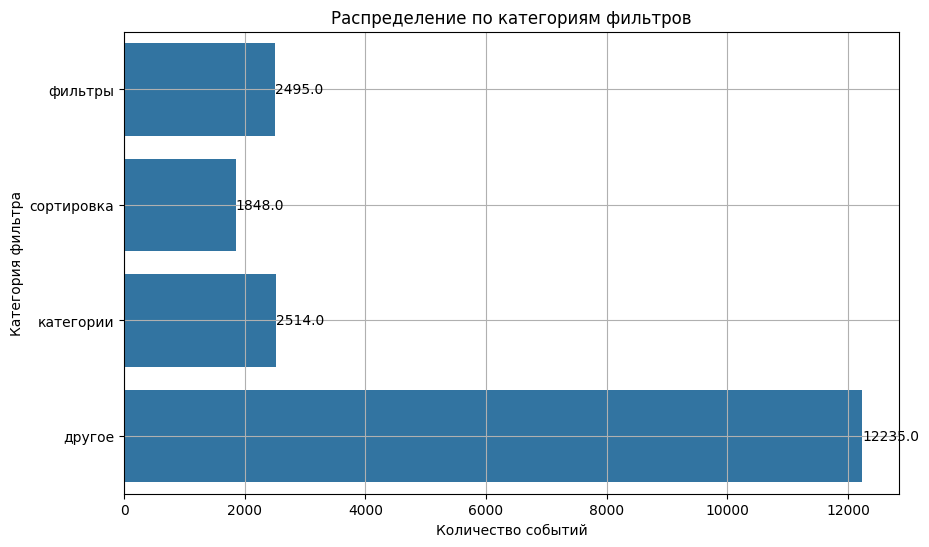

In [ ]:
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Создаем словарь для категоризации
category_mapping = {
    # Фильтры
    'выбра': 'фильтры',
    'фильтр выбра': 'фильтры',
    'фильтр': 'фильтры',
    'оплат на мест без предоплат': 'фильтры',
    'индивидуальн': 'фильтры',
    'минигрупп': 'фильтры',
    'завтр': 'фильтры',
    'сегодн': 'фильтры',

    # Сортировка
    'по рейтинг': 'сортировка',
    'снача сам дешев': 'сортировка',
    'снача сам популярн': 'сортировка',
    'сортировк': 'сортировка',
    'популярн': 'сортировка',
    'сортировк по рейтинг': 'сортировка',
    'сортировк снача сам дешев': 'сортировка',
    'сортировк снача сам популярн': 'сортировка',
    'by rating': 'сортировка',

    # Категории
    'группов': 'категории',
    'категор': 'категории',
    'обзорн': 'категории',
    'автобусн': 'категории',
    'необычн': 'категории',
    'категор все': 'категории',
    'пешеходн': 'категории',
    'для дет': 'категории',
    'гастрономическ': 'категории',
    'выездн': 'категории',
    'трансфер': 'категории',
    'билет без очеред': 'категории',
    'show offers': 'категории',
    'по пригород': 'категории',
    'морск прогулк': 'категории',
    'однодневн': 'категории',
    'авторск': 'категории',
    'активн отд': 'категории',
    'истор и архитектур': 'категории',
    'истор и культур': 'категории',
    'новогодн': 'категории',
    'в гор': 'категории',
    'развлечен': 'категории',
    'джиппинг': 'категории',
    'категор необычн': 'категории',
    'главн достопримечательн': 'категории',
    'на нов год и рождеств': 'категории',
    'категор автобусн': 'категории',
    'купальн и спа': 'категории',
    'categories': 'категории'
}

# Функция для определения категории
def get_category(text):
    if pd.isna(text):
        return 'другое'
    for key in category_mapping:
        if key in text:
            return category_mapping[key]
    return 'другое'

# Создаем новый столбец
df['filter_category'] = df['text_generalized'].apply(get_category)

# Проверяем распределение категорий
print(df['filter_category'].value_counts())

plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, y='filter_category', order=['фильтры', 'сортировка', 'категории', 'другое'])
plt.title('Распределение по категориям фильтров')
plt.xlabel('Количество событий')
plt.ylabel('Категория фильтра')
plt.grid()

# Добавление подписей на столбцы
for p in ax.patches:
    width = p.get_width()
    plt.text(width+5, p.get_y() + p.get_height()/2,
             '{:1}'.format(width),
             ha='left', va='center')  # Выравнивание текста

plt.show()

In [ ]:
df.head(5)

,event_category,event_action,event_label,total_events,unique_events,city,text,text_stemmed,text_generalized,filter_category
0,city_landing,price_button_submit,Tula / Показать предложения (11),8,7,Tula,Показать предложения,показа предложен,показа предложен,другое
1,city_landing,price_button_submit,Sochi / Показать предложения (39),12,10,Sochi,Показать предложения,показа предложен,показа предложен,другое
2,city_landing,search-tools-button_open,Penza / Сортировка,2,2,Penza,Сортировка,сортировк,сортировк,сортировка
3,city_landing,filters-categories_click,Gelendzhik / ЭКСКУРСИИ В ГЕЛЕНДЖИКЕ ЦЕНЫ,1,1,Gelendzhik,ЭКСКУРСИИ В ГЕЛЕНДЖИКЕ ЦЕНЫ,экскурс в геленджик цен,экскурс,другое
4,city_landing,price_button_submit,Moscow / Показать предложения (345),2,2,Moscow,Показать предложения,показа предложен,показа предложен,другое


Получается, что наиболее востребованный раздел с категориями. "Категории" и "Фильтры" показывают примерно одинаковое количество событий. Это предполагает, что пользователи в равной степени используют выбор категорий и применение фильтров для поиска нужной информации.

"Сортировка" - наименее часто используемый раздел. Это может указывать на то, что пользователи в основном используют фильтры и категории для сужения результатов, прежде чем прибегать к сортировке. Или же, возможно, функциональность сортировки менее заметна или менее удобна для пользователей.

## Вопрос 4 Как часто люди пользуются выбором цены?

Это действия:

price_first

price_second

price_third

In [ ]:
price_events = df[df['event_action'].isin(['price_first', 'price_second', 'price_third'])]
price_usage = price_events['unique_events'].sum()
print('Всего уникальных пользователей, которые воспользовались выбором цены: ', price_usage)
print('Процент от всех уникальных пользователей: ', round(price_usage/df.unique_events.sum()*100, 2), '%')
print('Процент от всех уникальных пользователей, которые пользовались фильтрами: ', round(price_usage/df[df.event_action!='Page Visit'].unique_events.sum()*100,2), '%')

Всего уникальных пользователей, которые воспользовались выбором цены:  9266
Процент от всех уникальных пользователей:  0.55 %
Процент от всех уникальных пользователей, которые пользовались фильтрами:  3.14 %


In [ ]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'colab'

# Фильтруем события по цене
price_events = df[df['event_action'].isin(['price_first', 'price_second', 'price_third'])]

# Группируем по типу фильтра цены
price_stats = price_events.groupby('event_action')['unique_events'].sum().reset_index()

# Переименовываем для понятности
price_names = {
    'price_first': 'Первый вариант цены',
    'price_second': 'Второй вариант цены',
    'price_third': 'Третий вариант цены'
}
price_stats['price_filter'] = price_stats['event_action'].map(price_names)

# Создаем интерактивную круговую диаграмму
fig = px.pie(price_stats,
             values='unique_events',
             names='price_filter',
             title='Распределение использования фильтров цены',
             hole=0.3,
             color_discrete_sequence=px.colors.sequential.Viridis)

# Добавляем подписи с абсолютными значениями
fig.update_traces(textinfo='percent+value',
                  hovertemplate='<b>%{label}</b><br>Пользователей: %{value:,}<br>Доля: %{percent}',
                  pull=[0.1, 0, 0])  # Немного выдвигаем первый сегмент

# Настраиваем оформление
fig.update_layout(
    height=500,
    showlegend=True,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.2,
        xanchor="center",
        x=0.5
    )
)

fig.show()

In [ ]:
# Топ-10 городов по использованию фильтров цены
top_cities_price = price_events.groupby('city')['unique_events'].sum().nlargest(10).reset_index()

fig = px.bar(top_cities_price,
             x='unique_events',
             y='city',
             orientation='h',
             title='Топ-10 городов по использованию фильтров цены',
             labels={'unique_events': 'Количество уникальных пользователей', 'city': 'Город'},
             color='unique_events',
             color_continuous_scale='Viridis')

fig.update_traces(texttemplate='%{x:,}', textposition='outside')
fig.update_layout(height=500, yaxis={'categoryorder':'total ascending'})
fig.show()

Основной вывод: Санкт-Петербург и Калининград - лидеры по использованию фильтров цены, значительно опережая Москву и другие города. Стоит отметить, что эти города были также в топе в целом по использованию фильтров. Возможно, в этих городах в целом много экскурсий и они в разном ценовом диапазоне, поэтому пользователю фильтр по цене является очень полезным. Можно исследовать пользовательские пути в Санкт-Петербурге и Калининграде, чтобы понять, как они используют фильтры цены и какие улучшения можно внедрить для других городов.
На основе такого анализа также можно думать о каких-либо рекламных акциях в этих городах, чтобы увеличить конверсию.

## Дополнительные инсайты

### Кластеризация городов по поведению пользователей

In [ ]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def optimal_cluster_analysis(data, max_clusters=10):
    """
    Автоматически определяет оптимальное число кластеров с визуализацией и пояснениями
    Возвращает: оптимальное число кластеров, пояснения, графики
    """
    # Нормализация данных
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)

    # Метрики для оценки
    metrics = {
        'Inertia': [],
        'Silhouette': [],
        'Calinski-Harabasz': [],
        'Davies-Bouldin': []
    }

    cluster_range = range(2, max_clusters+1)
    best_k = 2
    explanations = []

    # Вычисляем метрики для разного числа кластеров
    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(scaled_data)

        metrics['Inertia'].append(kmeans.inertia_)
        metrics['Silhouette'].append(silhouette_score(scaled_data, labels))
        metrics['Calinski-Harabasz'].append(calinski_harabasz_score(scaled_data, labels))
        metrics['Davies-Bouldin'].append(davies_bouldin_score(scaled_data, labels))

    # Анализ метрик
    ## Метод локтя (Inertia)
    elbow_k = np.argmin(np.diff(metrics['Inertia'], 2)) + 3  # +3 из-за двойной разницы и смещения индексов
    explanations.append(f"Метод локтя (Inertia) предполагает {elbow_k} кластеров (точка изгиба на графике).")

    ## Silhouette Score (чем выше, тем лучше)
    silhouette_k = cluster_range[np.argmax(metrics['Silhouette'])]
    explanations.append(f"Silhouette Score максимален для {silhouette_k} кластеров (значение: {max(metrics['Silhouette']):.2f}).")

    ## Calinski-Harabasz (чем выше, тем лучше)
    ch_k = cluster_range[np.argmax(metrics['Calinski-Harabasz'])]
    explanations.append(f"Calinski-Harabasz Index максимален для {ch_k} кластеров (значение: {max(metrics['Calinski-Harabasz']):.2f}).")

    ## Davies-Bouldin (чем ниже, тем лучше)
    db_k = cluster_range[np.argmin(metrics['Davies-Bouldin'])]
    explanations.append(f"Davies-Bouldin Index минимален для {db_k} кластеров (значение: {min(metrics['Davies-Bouldin']):.2f}).")

    # Определяем консенсусное k
    candidates = [elbow_k, silhouette_k, ch_k, db_k]
    best_k = max(set(candidates), key=candidates.count)
    explanations.append(f"\nКонсенсусное решение: оптимальное число кластеров = {best_k}")

    # Визуализация
    plt.figure(figsize=(15, 10))

    # График Inertia (метод локтя)
    plt.subplot(2, 2, 1)
    plt.plot(cluster_range, metrics['Inertia'], 'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method')
    plt.axvline(x=elbow_k, color='r', linestyle='--')

    # График Silhouette
    plt.subplot(2, 2, 2)
    plt.plot(cluster_range, metrics['Silhouette'], 'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score')
    plt.axvline(x=silhouette_k, color='r', linestyle='--')

    # График Calinski-Harabasz
    plt.subplot(2, 2, 3)
    plt.plot(cluster_range, metrics['Calinski-Harabasz'], 'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Calinski-Harabasz Score')
    plt.title('Calinski-Harabasz Index')
    plt.axvline(x=ch_k, color='r', linestyle='--')

    # График Davies-Bouldin
    plt.subplot(2, 2, 4)
    plt.plot(cluster_range, metrics['Davies-Bouldin'], 'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Davies-Bouldin Score')
    plt.title('Davies-Bouldin Index')
    plt.axvline(x=db_k, color='r', linestyle='--')

    plt.tight_layout()
    plt.show()

    return best_k, explanations

In [ ]:
# Применяем к нашим данным
city_behavior = df.pivot_table(
    index='city',
    columns='event_action',
    values='unique_events',
    aggfunc='sum',
    fill_value=0
)
city_behavior

event_action,Page Visit,clear_filter_mobile,dates_filter_mobile,end_date_click,filters-categories_click,pay-type_checkbox,price_button_close,price_button_submit,price_first,price_second,price_third,search-tools-button_open,start_date_click,ticket-type_checkbox
city,,,,,,,,,,,,,,
Aachen,4,0,0,0,0,0,0,0,0,0,0,0,0,0
Abakan,115,0,1,2,2,2,0,9,0,1,0,10,3,6
Abano Terme,7,0,0,0,0,0,0,0,0,0,0,0,0,0
Abkhazia,271,1,0,0,1,1,1,4,0,0,0,7,1,4
Abrau-Durso,4148,0,10,7,28,14,13,40,0,0,0,76,12,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zheleznovodsk,3767,5,20,20,114,13,29,98,13,4,0,168,30,44
Zhukovsky,51,0,0,0,0,0,0,0,0,0,0,0,0,0
Zurich,72,0,1,1,2,1,0,3,0,0,0,5,1,3


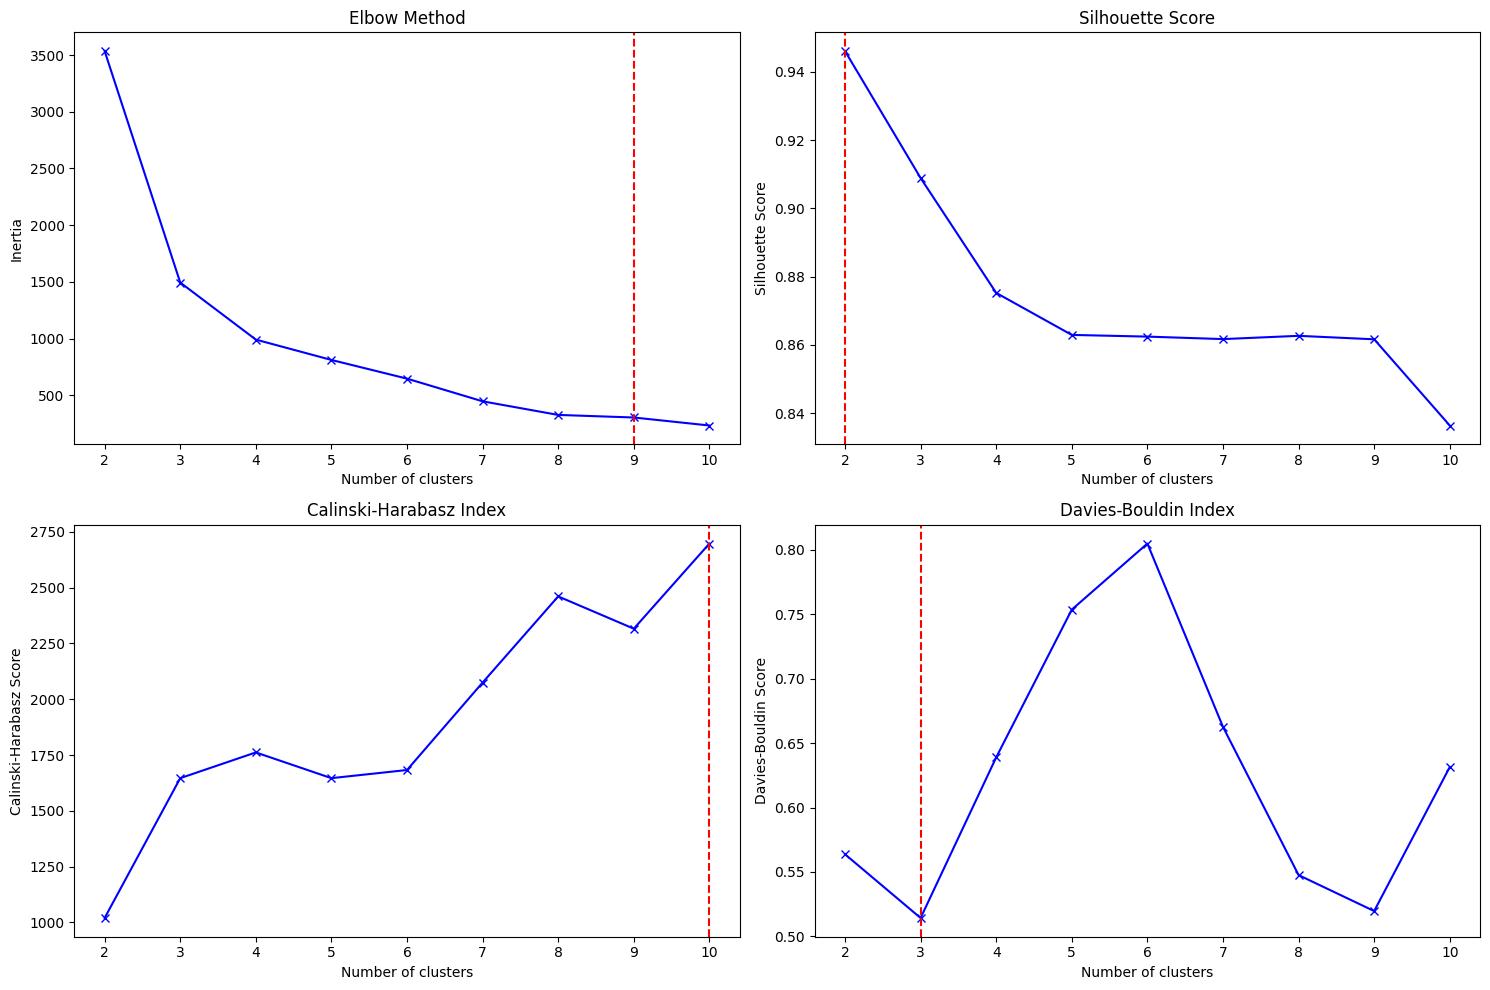

Метод локтя (Inertia) предполагает 9 кластеров (точка изгиба на графике).
Silhouette Score максимален для 2 кластеров (значение: 0.95).
Calinski-Harabasz Index максимален для 10 кластеров (значение: 2697.68).
Davies-Bouldin Index минимален для 3 кластеров (значение: 0.51).

Консенсусное решение: оптимальное число кластеров = 3


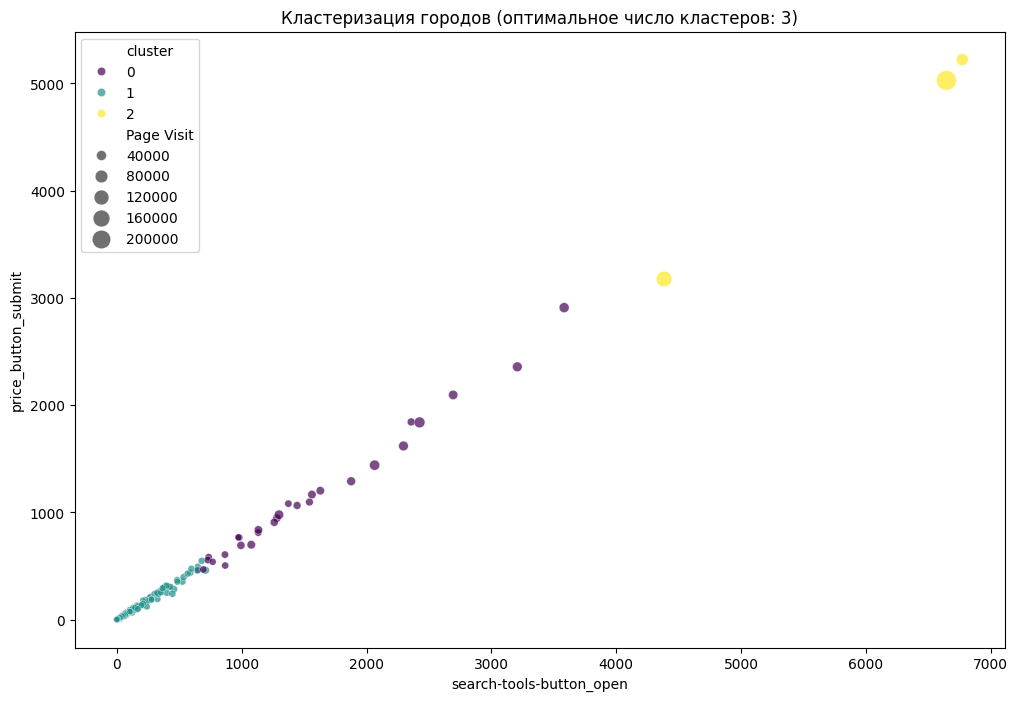

In [ ]:
optimal_k, explanations = optimal_cluster_analysis(city_behavior)

# Выводим пояснения
print("\n".join(explanations))

# Выполняем финальную кластеризацию с оптимальным k
scaler = StandardScaler()
scaled_data = scaler.fit_transform(city_behavior)
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
city_behavior['cluster'] = kmeans.fit_predict(scaled_data)

# Визуализация результатов
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=city_behavior,
    x='search-tools-button_open',
    y='price_button_submit',
    hue='cluster',
    palette='viridis',
    size='Page Visit',
    sizes=(20, 200),
    alpha=0.7
)
plt.title(f'Кластеризация городов (оптимальное число кластеров: {optimal_k})')
plt.show()

Более удобный интерактивный график:

In [ ]:
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Подготовка данных
city_behavior = df.pivot_table(
    index='city',
    columns='event_action',
    values='unique_events',
    aggfunc='sum',
    fill_value=0
)

# Нормализация и кластеризация
scaler = StandardScaler()
scaled_data = scaler.fit_transform(city_behavior)
kmeans = KMeans(n_clusters=3, random_state=42)
city_behavior['cluster'] = kmeans.fit_predict(scaled_data)

# Применяем PCA для визуализации многомерных данных
pca = PCA(n_components=2)
pca_results = pca.fit_transform(scaled_data)
city_behavior['PCA1'] = pca_results[:, 0]
city_behavior['PCA2'] = pca_results[:, 1]

# Создаем интерактивный график
fig = px.scatter(
    city_behavior.reset_index(),
    x='PCA1',
    y='PCA2',
    color='cluster',
    hover_name='city',
    hover_data={
        'PCA1': False,
        'PCA2': False,
        'cluster': True,
        'search-tools-button_open': True,
        'price_button_submit': True,
        'Page Visit': True,
        'filters-categories_click': True
    },
    title='Кластеризация городов по использованию фильтров (3 кластера)',
    width=1000,
    height=700,
    color_discrete_sequence=px.colors.qualitative.Plotly
)

# Настраиваем отображение
fig.update_layout(
    hovermode='closest',
    xaxis_title=f'PCA1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)',
    yaxis_title=f'PCA2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)',
    legend_title='Кластер'
)

# Улучшаем подсказки
fig.update_traces(
    marker=dict(size=12, line=dict(width=1, color='DarkSlateGrey')),
    hovertemplate=(
        "<b>%{hovertext}</b><br><br>"
        "Кластер: %{customdata[0]}<br>"
        "price_button_submit: %{customdata[2]}<br>"
        "Всего посещений: %{customdata[3]}<br>"
        "<extra></extra>"
    )
)

fig.show()

# Анализ центроидов кластеров
centroids = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=city_behavior.columns[:-3]  # Исключаем добавленные колонки
)
print("\nСредние значения по кластерам:")
centroids


Средние значения по кластерам:


event_action,Page Visit,clear_filter_mobile,dates_filter_mobile,end_date_click,filters-categories_click,pay-type_checkbox,price_button_close,price_button_submit,price_first,price_second,price_third,search-tools-button_open,start_date_click,ticket-type_checkbox
0,20075.862069,51.758621,151.724138,188.689655,1122.896552,89.965517,211.310345,1107.586207,113.448276,33.655172,9.862069,1500.103448,230.827586,288.620690
1,595.610032,1.076052,4.242718,5.810680,25.241100,2.686084,5.001618,28.344660,3.200647,0.647249,0.224919,39.593851,7.228155,9.846278
2,144730.333333,207.333333,1083.333333,891.666667,4792.000000,398.666667,809.000000,4475.333333,469.333333,206.333333,56.666667,5933.666667,1113.333333,1154.333333


График показывает результаты кластеризации городов на основе использования различных фильтров.  Визуализация выполнена с помощью метода главных компонент (PCA), который снижает размерность данных, сохраняя при этом максимальную вариативность.  Точки на графике представляют города, а цвет указывает на кластер, к которому город принадлежит.

Интерпретация кластеров:

График демонстрирует три кластера:

- Кластер 1 (пурпурный):  Большинство городов сгруппированы в этом кластере. Это, вероятно, города со средним уровнем использования фильтров.  Они демонстрируют относительно сбалансированное использование различных типов фильтров.

- Кластер 2 (желтый):  Это выбросы, города с очень высоким уровнем использования фильтров.  Их поведение значительно отличается от поведения большинства городов.  Это могут быть крупные города или города с очень специфическим спросом, где пользователи активно используют фильтры для поиска.

- Кластер 0 (темно-синий):  Этот кластер также содержит города с низким уровнем использования фильтров, но их распределение отличается от кластера 1.  Это может указывать на другую модель использования фильтров в этих городах.


Кластеризация полезна тем, что позволяет сегментировать города по поведению пользователей относительно использования фильтров. Это очень ценная информация для продуктового аналитика и может помочь в решении различных задач:

- Целевая реклама:  Можно создавать персонализированные рекламные кампании для разных кластеров городов, акцентируя внимание на наиболее эффективных типах фильтров для каждой группы.  Например, для кластера 2 можно предложить более продвинутые фильтры или функции.

- Разработка продукта:  Анализ поведения городов в разных кластерах поможет определить, какие фильтры работают лучше, а какие нуждаются в улучшении.  Информация о городах из кластера 0 может показать, какие аспекты пользовательского опыта или функциональности фильтров нужно улучшить для повышения их использования.

- Локализация продукта:  Кластеризация позволяет адаптировать продукт под потребности разных регионов.  Например, для городов кластера 2 могут быть предложены дополнительные параметры или настройки фильтров, не нужные для городов кластера 1.

- Понимание пользовательского поведения:  Кластеризация помогает понять, какие факторы влияют на использование фильтров, например, культурные, экономические или географические факторы.

- Предсказательная аналитика:  Можно использовать кластеры для предсказания будущих действий пользователей в разных городах.  Например, можно предсказать вероятность использования конкретного фильтра в новом городе, основываясь на его кластерной принадлежности.

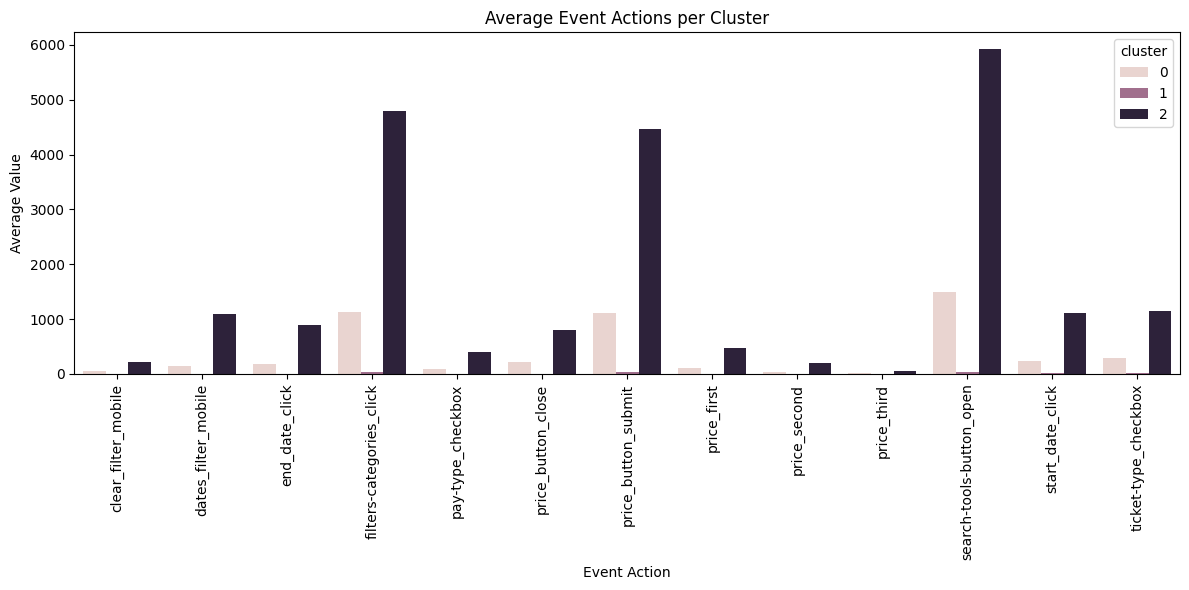

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

centroids=centroids.drop(columns='Page Visit')
centroids = centroids.T.reset_index()
centroids = centroids.rename(columns={'index': 'event_action'})

# Сгруппируйте данные по event_action и кластеру и посчитайте средние значения
melted_df = centroids.melt(id_vars=['event_action'], var_name='cluster', value_name='value')


plt.figure(figsize=(12, 6))
sns.barplot(x='event_action', y='value', hue='cluster', data=melted_df)
plt.xticks(rotation=90)
plt.xlabel('Event Action')
plt.ylabel('Average Value')
plt.title('Average Event Actions per Cluster')
plt.tight_layout()
plt.show()

График показывает среднее количество различных событий (действий с фильтрами) для каждого из трех кластеров пользователей.

-  Кластер 2 (темно-фиолетовый) явно выделяется активным использованием большинства фильтров, особенно "filters-categories_click" и "search-tools-button_open". Это кластер наиболее активных пользователей, использующих фильтры для навигации и поиска.
-  Кластер 0 (бежевый) показывает умеренное использование некоторых фильтров, но гораздо менее интенсивное, чем кластер 2. "filters-categories_click" и "search-tools-button_open" также относительно популярны в этом кластере, но в меньшей степени.
-  Кластер 1 (серо-фиолетовый) демонстрирует очень низкую активность в отношении всех фильтров. Пользователи в этом кластере практически не используют фильтры.

Вывод: Существует заметная разница в поведении разных кластеров пользователей относительно использования фильтров. Кластер 2 - ядро "продвинутых пользователей", кластер 0 - "средние пользователи", а кластер 1 - "пассивные пользователи". Дальнейший анализ должен быть направлен на понимание причин такого различия и разработку стратегий для стимулирования использования фильтров пользователями из кластера 1.

### Текстовая аналитика для фильтров

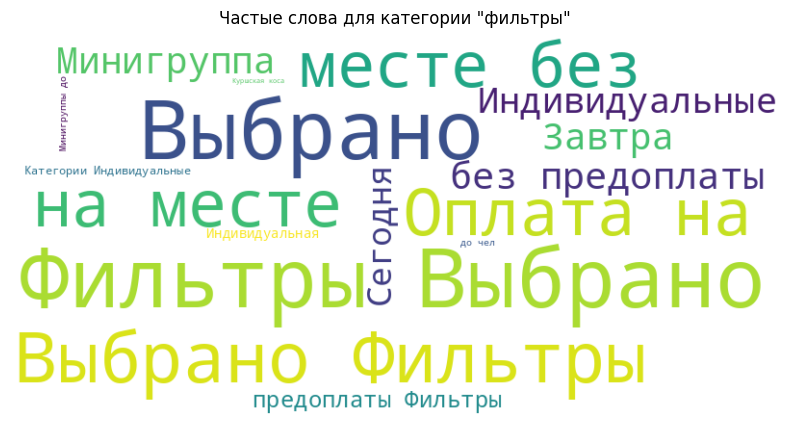

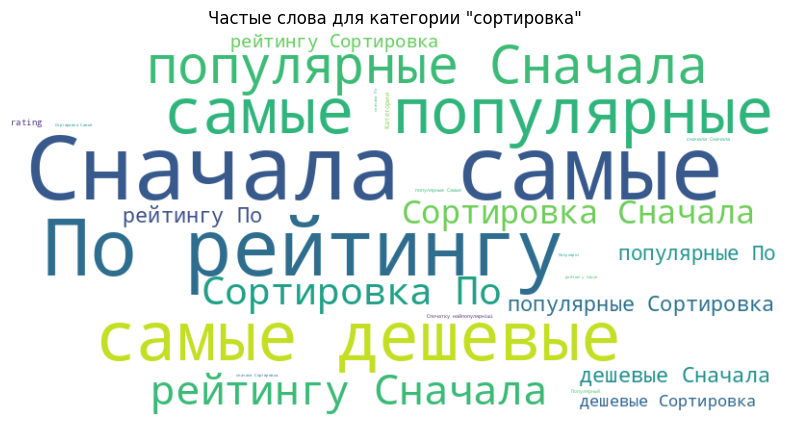

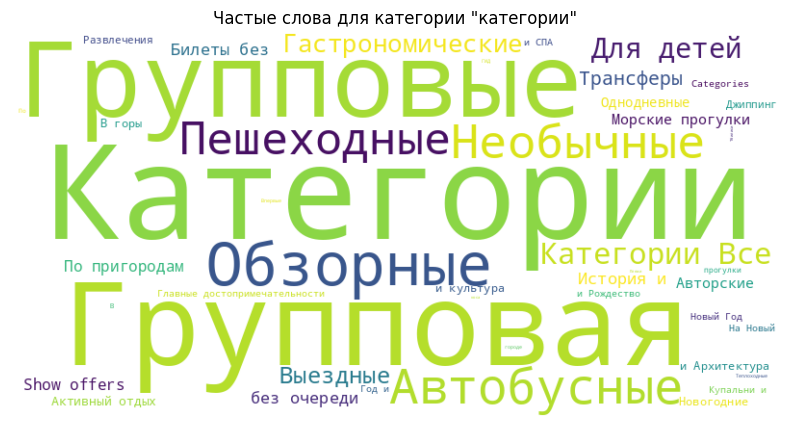

In [ ]:
from wordcloud import WordCloud

# Анализ текстовых меток для каждого типа фильтра
for category in ['фильтры', 'сортировка', 'категории']:
    text = ' '.join(df[df['filter_category'] == category]['text'].dropna())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Частые слова для категории "{category}"')
    plt.axis('off')
    plt.show()

По таком графику наглядно можно уивдеть, на какой текст пользователи чаще кликают в различных разделах. Его можно ещё почистить, чтобы он был ещё более информативным, но пока это не является целью.

### Корреляция между действиями пользователей

Рассмотрим корреляцию между фильтрами в различных городах.

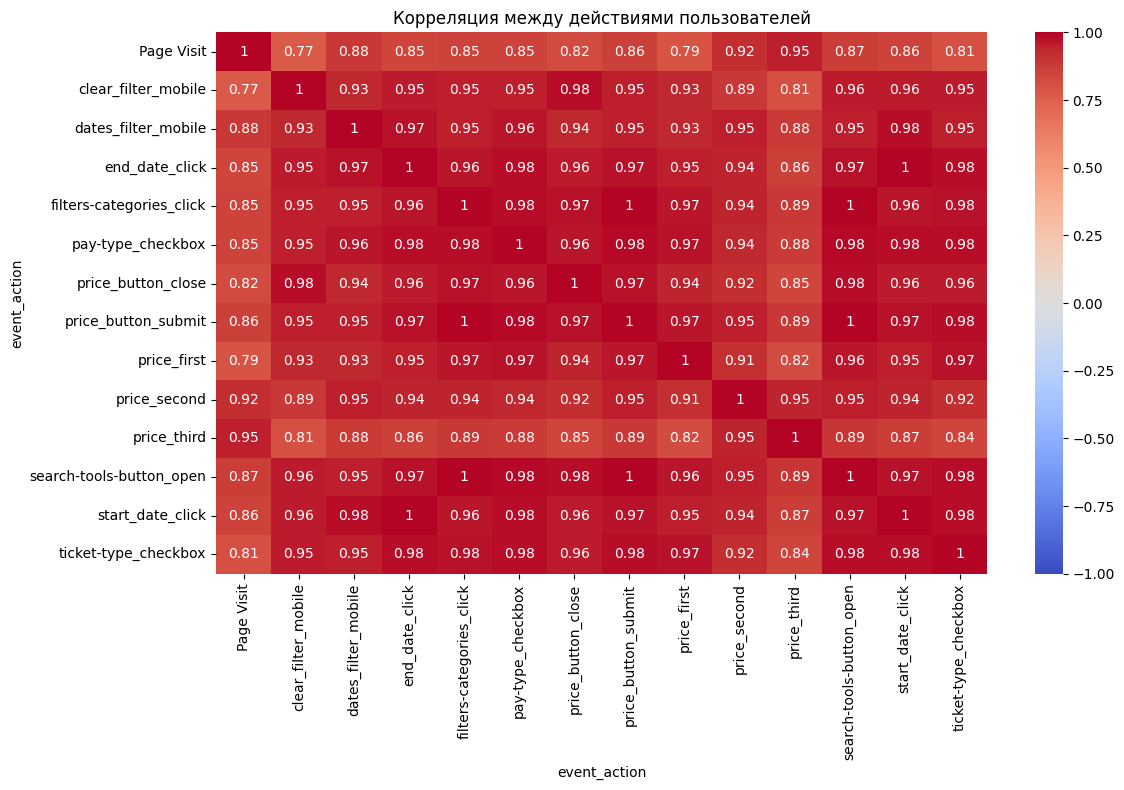

In [ ]:
# Группируем данные по городу и событию
event_corr = df.pivot_table(index='city', columns='event_action', values='unique_events', aggfunc='sum')

# Рассчитаем корреляцию между действиями
corr_matrix = event_corr.corr()

# Визуализируем
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Корреляция между действиями пользователей')
plt.tight_layout()
plt.show()

Как видно, корреляция между количеством использования фильтров очень сильная, что в данном анализе логично, так как фильтры взаимосвязаны.

# Задание 2

In [ ]:
import numpy as np
from statsmodels.stats.proportion import proportions_ztest

# Данные
count = np.array([300, 450])  # Бронирования
nobs = np.array([5000, 5000]) # Посетители

# Z-тест (двусторонний)
z_stat, p_value = proportions_ztest(count, nobs, alternative='two-sided')

print(f"Z-статистика: {z_stat:.3f}")
print(f"P-value: {p_value:.5f}")

# Относительный прирост конверсии
cr_a = 300 / 5000
cr_b = 450 / 5000
lift = (cr_b - cr_a) / cr_a * 100

print(f"Прирост конверсии: {lift:.1f}%")

Z-статистика: -5.695
P-value: 0.00000
Прирост конверсии: 50.0%
